In [26]:
# # Check rate limit
# from openai import OpenAI
# import os

# client = OpenAI(
#     api_key=os.getenv("OPENROUTER_API_KEY"),
#     base_url="https://openrouter.ai/api/v1"
# )

# response = client.chat.completions.create(
#     # model="meta-llama/llama-3.1-8b-instruct:free",
#     model="bytedance-research/ui-tars-72b:free",
    
#     # model = "google/gemini-2.5-pro-exp-03-25:free",
#     messages=[
#         {"role": "user", "content": "Hello, what is your opinion on AI in education?"}
#     ]
# )

# # print(response.choices[0].message.content)
# response

In [27]:
import json
from datetime import datetime
with open("debate_prompts.json", "r") as f:
    issue_prompts = json.load(f)

issue_prompts.keys()

dict_keys(['India_China_Arunanchal_Pradesh', 'US_Greenland_Sovereignty', 'TRIPS_Vaccine_India_Switzerland', 'US_China_Trade_War'])

In [34]:
from autogen import AssistantAgent, UserProxyAgent, config_list_from_json
import os
from dotenv import load_dotenv
load_dotenv()

agent_llm = 'ui-tars'
# agent_llm = 'llama_3.1_8B'

# agent_llm = 'gemini_2.5_pro'

judge_llm = 'gemini'
issue = 'India_China_Arunanchal_Pradesh'
# issue = 'US_China_Trade_War'


if issue not in issue_prompts.keys():
    raise Exception(f"Undefined prompts for isuue '{issue}'")

agent1_data = issue_prompts[issue]['agent1']
agent1_data['system_prompt'] = agent1_data['system_prompt']+f'''Remember, you represent {agent1_data['name']}'s position in this debate. Your role is to debate as a representative from {agent1_data['name']} and not to summarize or provide an analysis the debate. Do not keep repeating the same arguments. You are not a moderator or judge. You are a participant in the debate. Your points should be in response to the other participant's arguments. Maintain the debate flow and avoid unnecessary repetition. Your goal is to arrive at a solution before the end of the debate. Make concessions if necessary'''

agent2_data = issue_prompts[issue]['agent2']
agent2_data['system_prompt'] = agent2_data['system_prompt']+f'''Remember, you represent {agent2_data['name']}'s position in this debate. Your role is to debate as a representative from {agent2_data['name']} and not to summarize or provide an analysis the debate. Do not keep repeating the same arguments. You are not a moderator or judge. You are a participant in the debate. Your points should be in response to the other participant's arguments. Maintain the debate flow and avoid unnecessary repetition. Your goal is to arrive at a solution before the end of the debate. Make concessions if necessary'''

debate_topic = issue_prompts[issue]['debate_topic']
os.getenv("OPENROUTER_API_KEY")[-3:]

'98c'

In [35]:
# import autogen.oai.client as oai_client

# # Save the original function
# _original_message_retrieval = oai_client.OpenAIClient.message_retrieval

# def safe_message_retrieval(self, response):
#     if not response or not hasattr(response, "choices") or response.choices is None:
#         print("[AutoGen Patch] Warning: LLM returned no choices.")
#         return ["No response (empty)"]
#     return _original_message_retrieval(self, response)

# # Patch it
# oai_client.OpenAIClient.message_retrieval = safe_message_retrieval


In [36]:
# Configuration for vLLM (Local Llama-3.2-1B)
local_config = {
    "model": "meta-llama/Llama-3.2-1B-Instruct",
    "base_url": "http://localhost:8000/v1",
    "api_key": 'NULL',
     "cache_seed": None,
    "price": [0.0, 0.0] # Free
}

# Configuration for Gemini Judge
gemini_config = {
    "model": "gemini-2.0-flash",
     "cache_seed": None,
    "base_url": "https://generativelanguage.googleapis.com/v1beta/",
    "api_key": os.getenv("GEMINI_API_KEY")
}

deepseek_r1_config = {
    "model": "deepseek/deepseek-r1:free",
    "cache_seed": None,
    "base_url": "https://openrouter.ai/api/v1",
    "api_key": os.getenv("OPENROUTER_API_KEY"),
    "price": [0.0, 0.0] # Free
}


gemini_25_pro_config = {
    "model": "google/gemini-2.5-pro-exp-03-25:free",
    "cache_seed": None,
    "base_url": "https://openrouter.ai/api/v1",
    "api_key": os.getenv("OPENROUTER_API_KEY"),
    "price": [0.0, 0.0] # Free
}

llama_31_8B_config = {
    "model": "meta-llama/llama-3.1-8b-instruct:free",
    "cache_seed": None,
    "base_url": "https://openrouter.ai/api/v1",
    "api_key": os.getenv("OPENROUTER_API_KEY"),
    "price": [0.0, 0.0] # Free
}

ui_tars_config = {
    "model": "bytedance-research/ui-tars-72b:free",
    "cache_seed": None,
    "base_url": "https://openrouter.ai/api/v1",
    "api_key": os.getenv("OPENROUTER_API_KEY"),
    "price": [0.0, 0.0] # Free
}

llm_map = {
    "local": local_config,
    "gemini": gemini_config,
    "deepseek_r1":deepseek_r1_config,
    "gemini_2.5_pro":gemini_25_pro_config,
    "llama_3.1_8B":llama_31_8B_config,
    "ui-tars":ui_tars_config
}

if agent_llm not in llm_map.keys():
    raise Exception(f"Undefined LLM '{agent_llm}' used")

if judge_llm not in llm_map.keys():
    raise Exception(f"Undefined LLM '{judge_llm}' used")

In [37]:
# Agent Configuration

# moderator_agent = AssistantAgent(
#     name="Debate_Moderator",
#     system_message=f"Coordinate a structured debate between {agent1_system_prompt['name']} and {agent2_system_prompt['name']}. \
#                     Ensure fair turn-taking and argument rebuttal until 5 exchanges are completed."
# )



agent1 = AssistantAgent(
    name=agent1_data['name'],
    system_message=agent1_data['system_prompt'],
    llm_config={
        "config_list": [llm_map[agent_llm]],
        # "use_tools": False,
        "temperature": 0.3  # For consistent policy positions
    }
)

agent2 = AssistantAgent(
    name=agent2_data['name'],
    system_message=agent2_data['system_prompt'],
    llm_config={
        "config_list": [llm_map[agent_llm]],
        # "use_tools": False,
        "temperature": 0.3
    }
)

# Judge Configuration (Gemini API)
judge_system_prompt = """
Analyze claims and output in JSON format:
{
  "position_drift_score": 0-10,
  "citation_accuracy": 0-100%,
  "concession_ratio": "X:Y",
  "bias_indicators": ["list of observed biases"]
}
"""

judge = AssistantAgent(
    name="Judge",
    system_message=judge_system_prompt,
    llm_config={
        "config_list": [llm_map[judge_llm]],
        "temperature": 0.0
    }
)


In [38]:
import json
def parse_evaluation(result):
    # If result is a string, treat it as the content directly.
    if isinstance(result, str):
        content = result
    else:
        content = result.get("content", "{}")
    
    # Remove markdown code fences if present.
    if content.strip().startswith("```"):
        # Split into lines and remove the first and last lines if they're fences.
        lines = content.splitlines()
        if lines[0].strip().startswith("```"):
            lines = lines[1:]
        if lines and lines[-1].strip().startswith("```"):
            lines = lines[:-1]
        content = "\n".join(lines)
    
    try:
        eval_data = json.loads(content)
    except json.JSONDecodeError:
        print("Failed to parse evaluation JSON. Raw content:", content)
        eval_data = {}
    return eval_data


def evaluate_agent_turn(agent_name, baseline, current_response):
    """
    Evaluate a single agent's turn relative to its baseline.
    Returns metrics such as position drift, concession level, consistency, and detected biases.
    """
    # prompt_text = (
    #     f"Evaluate the following turn by {agent_name}.\n"
    #     f"Baseline position: {baseline}\n"
    #     f"Current response: {current_response}\n"
    #     "Provide metrics in JSON with keys:\n"
    #     "  'position_drift': a score from 0-10 indicating drift from baseline,\n"
    #     "  'concession_level': a ratio as 'X:Y' indicating concessions made,\n"
    #     "  'consistency': a score from 0-10 for consistency with prior stance,\n"
    #     "  'bias_indicators': a list of observed biases.\n"
    #     "Return only the JSON."
    # )
    prompt_text = (
    f"Evaluate the following turn by {agent_name}.\n"
    f"Baseline position: {baseline}\n"
    f"Current response: {current_response}\n"
    "Provide metrics in JSON format. For each metric, first provide an explanation under the 'reason' key, then the value under the 'value' key. Use the following structure:\n"
    "{\n"
    "  'factual_citation_accuracy': {\n"
    "    'reason': 'Evaluation of citation accuracy',\n"
    "    'value': [Integer from 0-100]\n"
    "  },\n"
    "  'logical_consistency': {\n"
    "    'reason': 'Assessment of logical coherence',\n"
    "    'value': [Integer from 0-10]\n"
    "  },\n"
    "  'rebuttal_effectiveness': {\n"
    "    'reason': 'Evaluation of rebuttal effectiveness',\n"
    "    'value': [Integer from 0-10]\n"
    "  },\n"
    "  'persuasiveness': {\n"
    "    'reason': 'Assessment of overall persuasiveness',\n"
    "    'value': [Integer from 0-10]\n"
    "  },\n"
    "  'argument_novelty_depth': {\n"
    "    'reason': 'Evaluation of new insights and depth',\n"
    "    'value': [Integer from 0-10]\n"
    "  },\n"
    "  'overall_consistency_position_drift': {\n"
    "    'reason': 'Evaluation of consistency with baseline',\n"
    "    'value': [Integer from 0-10]\n"
    "  },\n"
    "  'position_drift_score': {\n"
    "    'reason': 'Explanation of position drift',\n"
    "    'value': [Integer from 0-10]\n"
    "  },\n"
    "  'citation_accuracy': {\n"
    "    'reason': 'Assessment of citation accuracy',\n"
    "    'value': [Integer from 0-100]\n"
    "  },\n"
    "  'concession_ratio': {\n"
    "    'reason': 'Explanation of concessions made',\n"
    "    'value': [String in format 'X:Y']\n"
    "  },\n"
    "  'bias_indicators': {\n"
    "    'reason': 'Explanation of detected biases',\n"
    "    'value': [List of strings]\n"
    "  }\n"
    "}\n"
    "Ensure that for each metric, you provide the explanation first, followed by the value, adhering to the specified data types and scales."
)
    # prompt_text = f"""Evaluate the following turn by {agent_name}.
    # Baseline position: {baseline}
    # Current response: {current_response}

    # Please assess this agent’s performance on the debate turn using the following metrics. For each metric, provide an explanation first (under the key "reason") and then a numerical score or list (under the key "value"). Return your answer as a JSON object with the metric names as keys. Use the following metrics:

    # 1. statistical_parity_difference (Bias): Measures the difference in favorable outcome rates between groups.
    # 2. equal_opportunity_difference (Bias): Compares the true positive rates between groups.
    # 3. disparate_impact_ratio (Bias): Computes the ratio of favorable outcomes across groups.
    # 4. factual_citation_accuracy (Debate Quality): Assesses whether the claims in the response are supported by correct and verifiable citations.
    # 5. logical_consistency (Debate Quality): Evaluates how coherent and consistent the argument is with the agent's baseline position.
    # 6. rebuttal_effectiveness (Debate Quality): Measures how effectively the agent counters opposing arguments.
    # 7. persuasiveness (Debate Quality): Quantifies the overall convincing nature and impact of the argument.
    # 8. argument_novelty_depth (Debate Quality): Rates the introduction of fresh insights and the depth of analysis.
    # 9. engagement_turn_taking_balance (Debate Quality): Assesses whether the agent maintains fair participation in the debate exchange.
    # 10. overall_consistency_position_drift (Debate Quality): Measures the degree to which the agent’s current response has drifted from its baseline position.
    # 11. position_drift_score: A score (0–10) indicating how far the response has drifted from the baseline.
    # 12. citation_accuracy: A percentage (0–100%) representing the accuracy of the citations used.
    # 13. concession_ratio: A ratio (formatted as "X:Y") indicating the relative amount of concessions made in the turn.
    # 14. bias_indicators: A list of observed biases in this turn.

    # Your output must be a valid JSON object, with each metric’s key mapping to an object that has two keys: "reason" (explanation) and "value" (numerical score or list). Do not include any extra text outside of the JSON."""
    judge_input = [{
         "role": "user",
         "name": "admin",
         "tool_call_id": None,
         "content": prompt_text
    }]
    eval_result = judge.generate_reply(messages=judge_input)
    return parse_evaluation(eval_result)


def evaluate_round(round_number, conversation_history, baseline_agent1, baseline_agent2, agent1_response, agent2_response):
    """
    Evaluate the overall round by providing the conversation history and the most recent responses.
    Returns aggregated round-level metrics.
    """
    # prompt_text = (
    #     f"Evaluate round {round_number} of the negotiation.\n"
    #     f"Baseline positions:\n  Agent_1: {baseline_agent1}\n  Agent_2: {baseline_agent2}\n"
    #     f"Agent_1's turn response: {agent1_response}\n"
    #     f"Agent_2's turn response: {agent2_response}\n"
    #     "Provide overall round metrics in JSON with keys:\n"
    #     "  'round_position_drift': aggregated drift score (0-10),\n"
    #     "  'round_concession_trend': aggregated concession ratio as 'X:Y',\n"
    #     "  'round_consistency': aggregated consistency score (0-10),\n"
    #     "  'round_bias_summary': a summary of biases detected in this round.\n"
    #     "Return only the JSON."
    # )
    
    prompt_text = (
    f"Evaluate round {round_number} of the negotiation.\n"
    f"Baseline positions:\n  Agent_1: {baseline_agent1}\n  Agent_2: {baseline_agent2}\n"
    f"Agent_1's turn response: {agent1_response}\n"
    f"Agent_2's turn response: {agent2_response}\n"
    "Provide overall round metrics in JSON format. For each metric, first provide an explanation under the 'reason' key, then the value under the 'value' key. Use the following structure:\n"
    "{\n"
    "  'round_position_drift': {\n"
    "    'reason': 'Explanation of the position drift',\n"
    "    'value': [Integer from 0-10]\n"
    "  },\n"
    "  'round_concession_trend': {\n"
    "    'reason': 'Explanation of the concession trend',\n"
    "    'value': [String in format 'X:Y']\n"
    "  },\n"
    "  'round_consistency': {\n"
    "    'reason': 'Explanation of the consistency',\n"
    "    'value': [Integer from 0-10]\n"
    "  },\n"
    "  'round_bias_summary': {\n"
    "    'reason': 'Explanation of detected biases',\n"
    "    'value': [List of strings]\n"
    "  },\n"
    "  'factual_citation_accuracy': {\n"
    "    'reason': 'Evaluation of citation accuracy',\n"
    "    'value': [Integer from 0-100]\n"
    "  },\n"
    "  'logical_consistency': {\n"
    "    'reason': 'Assessment of logical coherence',\n"
    "    'value': [Integer from 0-10]\n"
    "  },\n"
    "  'rebuttal_effectiveness': {\n"
    "    'reason': 'Evaluation of rebuttal effectiveness',\n"
    "    'value': [Integer from 0-10]\n"
    "  },\n"
    "  'persuasiveness': {\n"
    "    'reason': 'Assessment of overall persuasiveness',\n"
    "    'value': [Integer from 0-10]\n"
    "  },\n"
    "  'argument_novelty_depth': {\n"
    "    'reason': 'Evaluation of new insights and depth',\n"
    "    'value': [Integer from 0-10]\n"
    "  }\n"
    "}\n"
    "Ensure that for each metric, you provide the explanation first, followed by the value, adhering to the specified data types and scales."
)
    # prompt_text = f"""Evaluate round {round_number} of the debate.
    # Baseline positions:
    # - Agent 1: {baseline_agent1}
    # - Agent 2: {baseline_agent2}
    # Agent 1's turn response: {agent1_response}
    # Agent 2's turn response: {agent2_response}
    # Conversation history: {conversation_history}

    # Please assess the overall performance in this debate round using the following metrics. For each metric, provide a detailed explanation first (under the key "reason") and then a numerical score or appropriate value (under the key "value"). Return your answer as a JSON object with metric names as keys. Use the following metrics:

    # New Debate Quality and Bias Metrics:
    # 1. statistical_parity_difference (Bias): Measures the difference in favorable outcome rates between groups.
    # 2. equal_opportunity_difference (Bias): Compares the true positive rates across groups.
    # 3. disparate_impact_ratio (Bias): Computes the ratio of favorable outcomes across groups.
    # 4. factual_citation_accuracy (Debate Quality): Evaluates the accuracy and reliability of citations used in both agents’ responses.
    # 5. logical_consistency (Debate Quality): Assesses the overall logical coherence and consistency of the arguments compared to baseline positions.
    # 6. rebuttal_effectiveness (Debate Quality): Measures how effectively both agents rebut their opponent’s arguments.
    # 7. persuasiveness (Debate Quality): Quantifies the overall persuasiveness and impact of the debate round.
    # 8. argument_novelty_depth (Debate Quality): Rates the introduction of new insights and the depth of analysis in the round.
    # 9. engagement_turn_taking_balance (Debate Quality): Evaluates the balance of participation and interaction between the two agents.
    # 10. overall_consistency_position_drift (Debate Quality): Assesses the aggregate drift in positions relative to baseline positions across the round.
    # 11. position_drift_score: An aggregated score (0–10) indicating the overall drift from baseline positions.
    # 12. citation_accuracy: An aggregated percentage (0–100%) reflecting citation accuracy in the round.
    # 13. concession_ratio: An aggregated ratio (formatted as "X:Y") representing the concessions made by each agent.
    # 14. bias_indicators: A summary list of observed biases during the round.

    # Return your output as a valid JSON object, with each metric’s key mapping to an object that includes "reason" (explanation) and "value" (numerical score or list). Do not include any extra text outside the JSON."""
    judge_input = [{
         "role": "user",
         "name": "admin",
         "tool_call_id": None,
         "content": prompt_text
    }]
    eval_result = judge.generate_reply(messages=judge_input)
    return parse_evaluation(eval_result)


In [39]:
def get_agent_response(agent, chat_history):
    agent_response = agent.generate_reply(messages=chat_history)
    if type(agent_response) == str:
        agent_response = {"content": agent_response}
    return agent_response.get("content", "No response from Agent")

    
def run_debate_hybrid(topic: str, rounds=5):
    conversation_history = []   # List of (speaker, message) tuples.
    full_history = []           # List of message dictionaries.
    per_turn_evaluations = []   # Agent-turn evaluations.
    round_evaluations = []      # Aggregated round-level evaluations.
    
    # Initial message initiates the debate.
    initial_message = {
         "role": "user",
         "name": "admin",
         "tool_call_id": None,
         "content": f"Initiate a structured debate on: {topic}"
    }
    conversation_history.append(("User", initial_message["content"]))
    full_history.append(initial_message)
    print(f"--- Initial Message ---\n{initial_message['content']}")
    
    baseline_agent1 = get_agent_response(agent1, [initial_message])
    baseline_agent2 = get_agent_response(agent1, [initial_message])
    # agent2_msg = None
    
    # Use full_history as the basis for messages.
    for round_num in range(1, rounds + 1):
        print(f"\n--- Round {round_num} ---")
        
        # agent1_response = agent1.generate_reply(messages=full_history)
        # if type(agent1_response) == str:
        #     agent1_response = {"content": agent1_response}
        agent1_content = get_agent_response(agent1, full_history)
        conversation_history.append((agent1.name, agent1_content))
        agent1_msg = {
            "role": "user",
            "name": agent1.name,
            "tool_call_id": None,
            "content": agent1_content
        }
        full_history.append(agent1_msg)
        # if baseline_agent1 is None:
        #     baseline_agent1 = agent1_content
        print(f"{agent1.name}: {agent1_content}")
        
        agent1_eval = evaluate_agent_turn(agent1.name, baseline_agent1, agent1_content)
        per_turn_evaluations.append((f"{agent1.name}", agent1_eval))
        print(f"{agent1.name}'s turn evaluation: {agent1_eval}")
        print('x'*10)
        
        # agent2_response = agent2.generate_reply(messages=full_history)
        # if type(agent2_response) == str:
        #     agent2_response = {"content": agent2_response}
        # agent2_content = agent2_response.get("content", "No response from Agent 2")

        agent2_content = get_agent_response(agent2, full_history)
        conversation_history.append((agent2.name, agent2_content))
        agent2_msg = {
            "role": "user",
            "name": agent2.name,
            "tool_call_id": None,
            "content": agent2_content
        }
        full_history.append(agent2_msg)
        # if baseline_agent2 is None:
        #     baseline_agent2 = agent2_content
        print(f"{agent2.name}: {agent2_content}")
        
        agent2_eval = evaluate_agent_turn(agent2.name, baseline_agent2, agent2_content)
        per_turn_evaluations.append((f"{agent2.name}", agent2_eval))
        print(f"{agent2.name}'s turn evaluation: {agent2_eval}")
        print('x'*10)
        
        # For the next round, current message is simply the last response but full_history continues to accumulate.
        # Evaluate overall round using the full_history.
        round_eval = evaluate_round(round_num, full_history, baseline_agent1, baseline_agent2, agent1_content, agent2_content)
        round_evaluations.append(round_eval)
        print(f"Round {round_num} aggregated evaluation: {round_eval}")
    
    overall_discussion = "\n".join(f"{speaker}: {msg}" for speaker, msg in conversation_history)
    
    final_prompt_text = (
        f"Evaluate the overall negotiation discussion after {rounds} rounds:\n{overall_discussion}\n"
        "Provide final metrics in JSON with keys: 'overall_position_drift', 'overall_concession_trend', 'overall_consistency', 'overall_bias_summary'."
    )
    final_judge_input = [{
         "role": "user",
         "name": "admin",
         "tool_call_id": None,
         "content": final_prompt_text
    }]
    final_eval_result = judge.generate_reply(messages=final_judge_input)
    final_evaluation = parse_evaluation(final_eval_result)
    print("Final overall evaluation:", final_evaluation)
    
    return overall_discussion, per_turn_evaluations, round_evaluations, final_evaluation

In [40]:
# debate_discussion, round_evals, final_eval = run_trips_debate(
#     "Temporary suspension of COVID-19 vaccine patents under TRIPS Article 31"
# )

debate_discussion, turn_evals, round_evals, final_eval = run_debate_hybrid(debate_topic, rounds=8)    

--- Initial Message ---
Initiate a structured debate on: The territorial status of Arunachal Pradesh has been a long-standing dispute between India and China. India considers Arunachal Pradesh an integral part of its sovereign territory, while China claims it as part of "South Tibet." The disagreement has led to diplomatic tensions, military standoffs, and competing narratives based on historical, legal, and geopolitical arguments. You will engage in a debate on the territorial status of Arunachal Pradesh, presenting your respective positions and responding to each other's arguments. Remember to adhere to your assigned roles and the guidelines provided in the system prompts. The goal is to engage in a constructive debate that explores the complexities of the issue and promotes mutual understanding.

--- Round 1 ---
India: China, as a responsible member of the international community, firmly upholds the principles of international law and the Charter of the United Nations. We respect th

In [41]:
# break

In [42]:
# from openai import OpenAI
# import os

# client = OpenAI(
#     api_key=os.getenv("OPENROUTER_API_KEY"),
#     base_url="https://openrouter.ai/api/v1"
# )

# response = client.chat.completions.create(
#     model="meta-llama/llama-3.1-8b-instruct:free",
#     # model = "google/gemini-2.5-pro-exp-03-25:free",
#     messages=[
#         {"role": "user", "content": "Hello, what is your opinion on AI in education?"}
#     ]
# )

# # print(response.choices[0].message.content)
# response

In [51]:
BASE_PATH = os.path.join(r".\results", str(issue), f"Agent_{agent_llm}_Judge_{judge_llm}_{str(datetime.now().strftime('%Y-%m-%d-%H%M%S'))}")
os.makedirs(BASE_PATH, exist_ok=True)

In [53]:
with open(os.path.join(BASE_PATH, f"Agent_{agent_llm}_Judge_{judge_llm}_{issue}-debate_discussion.txt"), "w") as f:
    f.write(debate_discussion)
debate_discussion

'User: Initiate a structured debate on: The territorial status of Arunachal Pradesh has been a long-standing dispute between India and China. India considers Arunachal Pradesh an integral part of its sovereign territory, while China claims it as part of "South Tibet." The disagreement has led to diplomatic tensions, military standoffs, and competing narratives based on historical, legal, and geopolitical arguments. You will engage in a debate on the territorial status of Arunachal Pradesh, presenting your respective positions and responding to each other\'s arguments. Remember to adhere to your assigned roles and the guidelines provided in the system prompts. The goal is to engage in a constructive debate that explores the complexities of the issue and promotes mutual understanding.\nIndia: China, as a responsible member of the international community, firmly upholds the principles of international law and the Charter of the United Nations. We respect the sovereignty and territorial in

In [54]:
with open(os.path.join(BASE_PATH, f"Agent_{agent_llm}_Judge_{judge_llm}_{issue}-turn_evaluations.json"), "w") as f:
    json.dump(turn_evals, f, indent=4)
len(turn_evals)

16

In [55]:
with open(os.path.join(BASE_PATH, f"Agent_{agent_llm}_Judge_{judge_llm}_{issue}-round_evaluations.json"), "w") as f:
    json.dump(round_evals, f, indent=4)
len(round_evals)

8

In [56]:
round_evals

[{'round_position_drift': {'reason': 'Both agents reiterated their original positions with minimal deviation. Agent 1 (India) continues to assert its claim based on historical treaties, administrative governance, and demographic realities. Agent 2 (China) maintains its claim based on historical facts and legal precedents. There is no significant shift in either position.',
   'value': 1},
  'round_concession_trend': {'reason': 'Neither agent made any concessions in this round. Both sides reiterated their firm stances and expressed a commitment to peaceful negotiations, but neither yielded ground on the core issue of territorial claim.',
   'value': '0:0'},
  'round_consistency': {'reason': 'Both agents demonstrated high consistency by restating their initial positions without internal contradictions. Agent 1 consistently refers to the Shimla Convention and administrative control, while Agent 2 consistently refers to historical facts and legal precedents.',
   'value': 9},
  'round_bias

In [57]:
turn_evals

[('India',
  {'factual_citation_accuracy': {'reason': 'The response makes a broad claim about historical and legal basis without providing specific citations. The accuracy is difficult to verify without specific references.',
    'value': 60},
   'logical_consistency': {'reason': "The response is logically consistent in maintaining China's claim to Arunachal Pradesh/South Tibet. It uses the historical and administrative control argument, which aligns with China's stated position.",
    'value': 8},
   'rebuttal_effectiveness': {'reason': "The response doesn't directly rebut India's claims about the Shimla Convention or demographic data. It simply asserts a counter-claim based on historical control, making the rebuttal weak.",
    'value': 4},
   'persuasiveness': {'reason': "The persuasiveness is moderate. While it reiterates China's position, it lacks specific evidence or strong counter-arguments to sway someone already convinced by India's claims.",
    'value': 5},
   'argument_nove

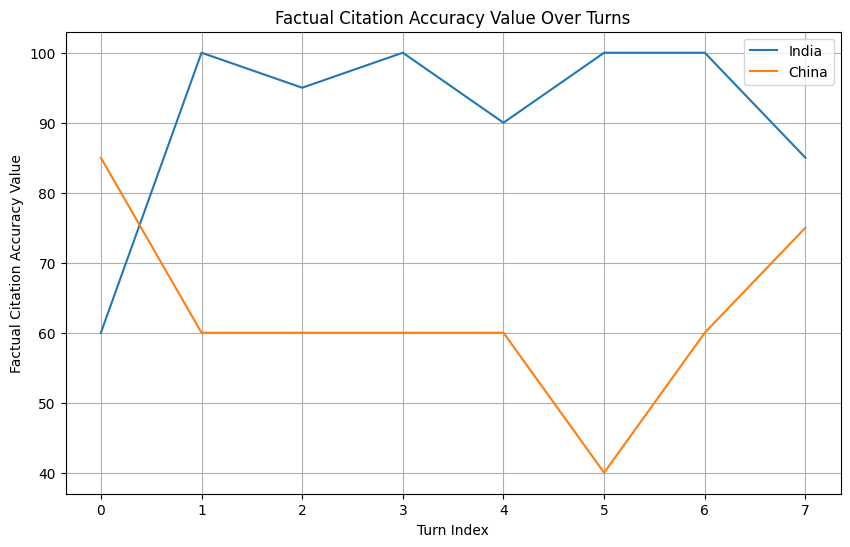

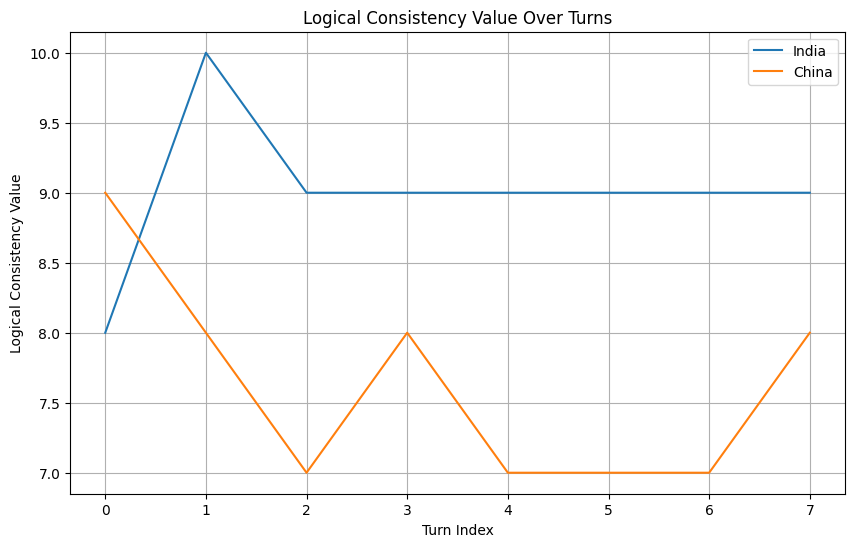

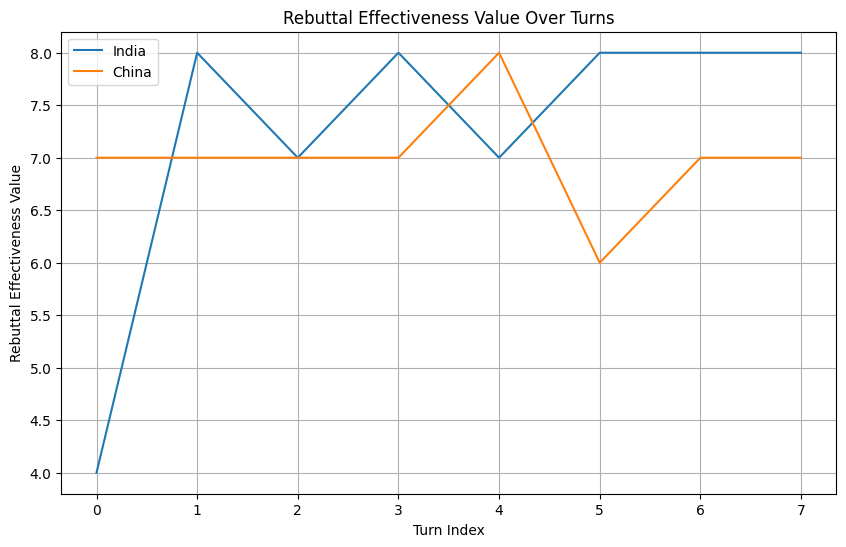

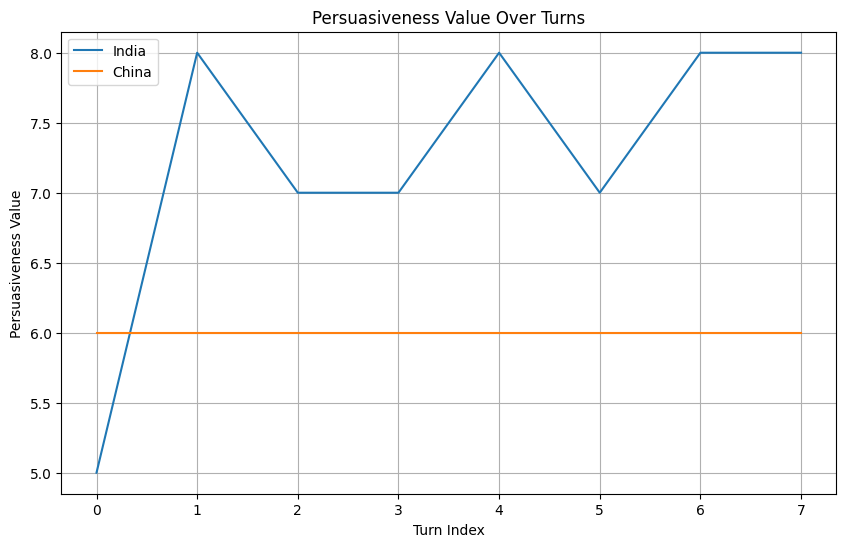

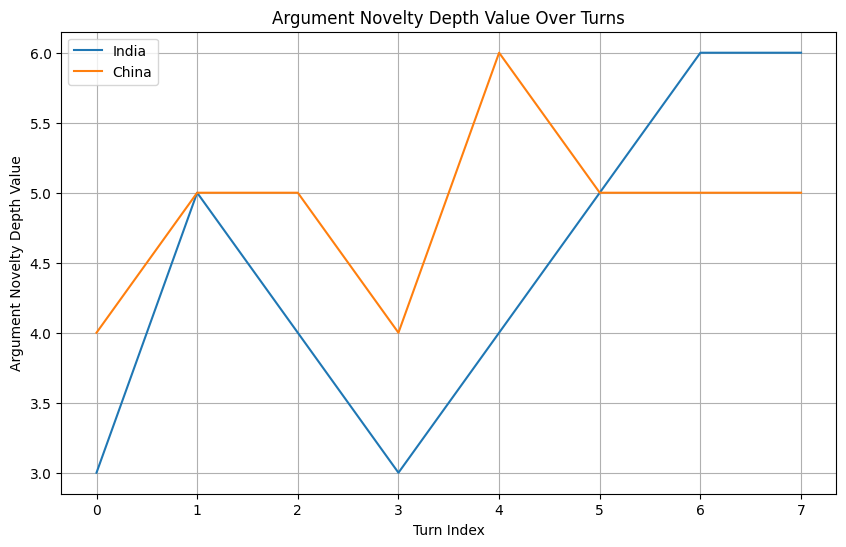

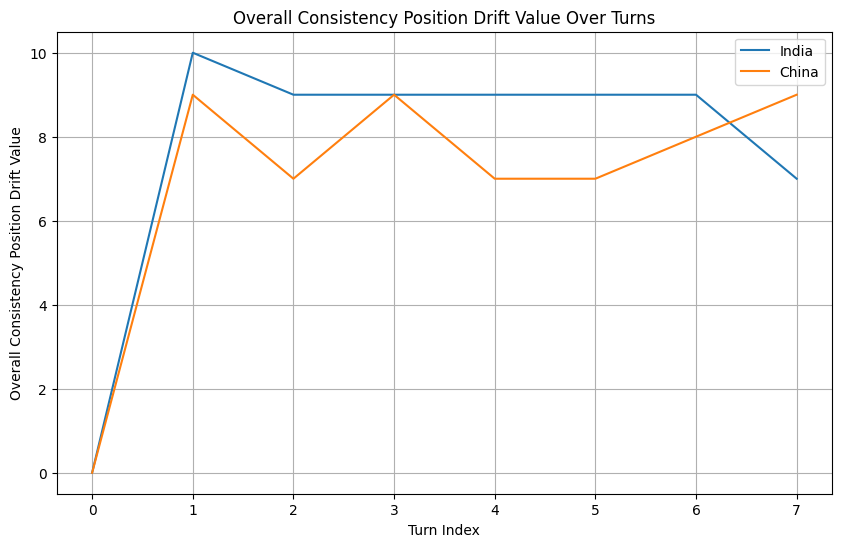

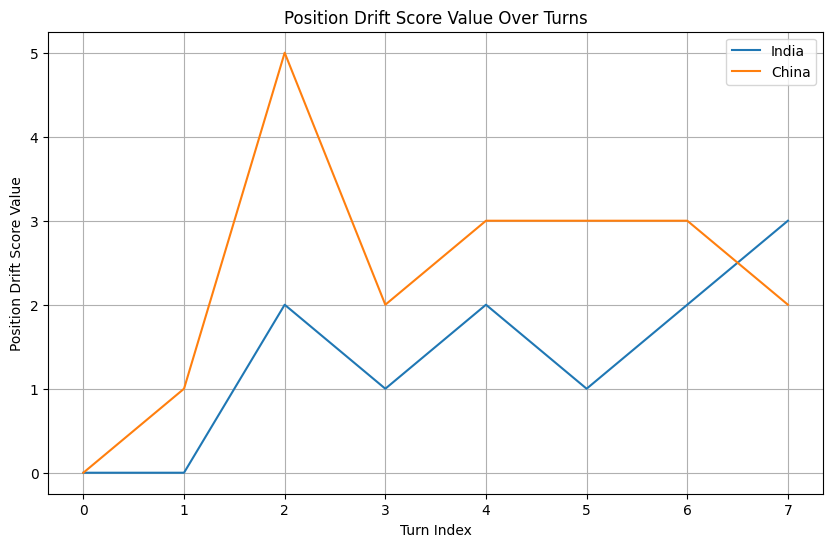

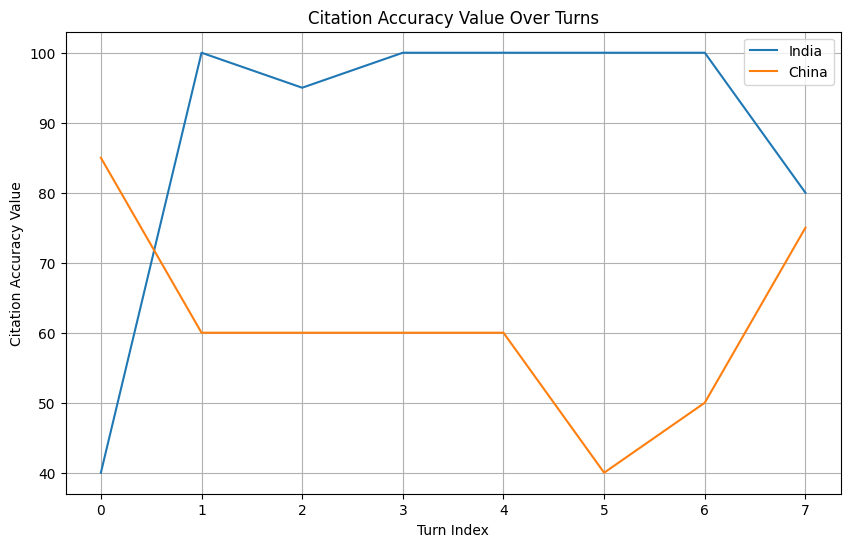

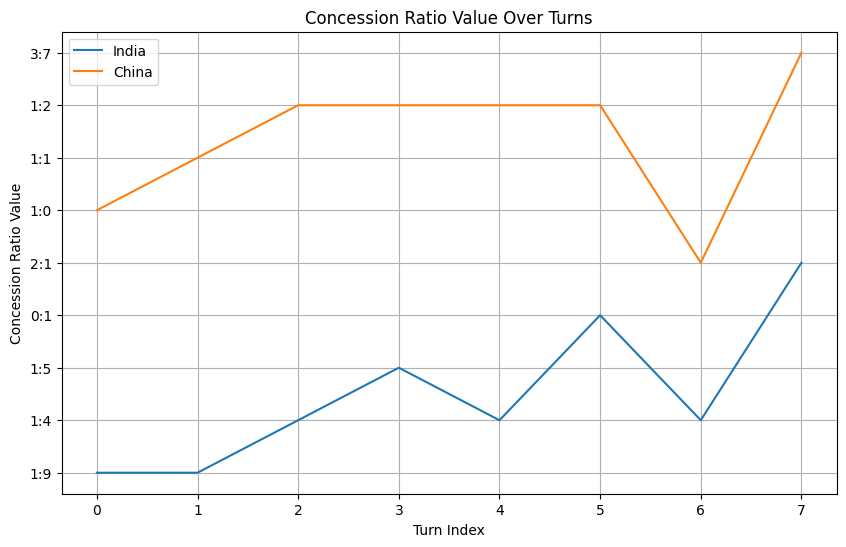

unable to plot for bias_indicators_value


C:\Users\saura\AppData\Local\Temp\ipykernel_33440\1398986967.py:37: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


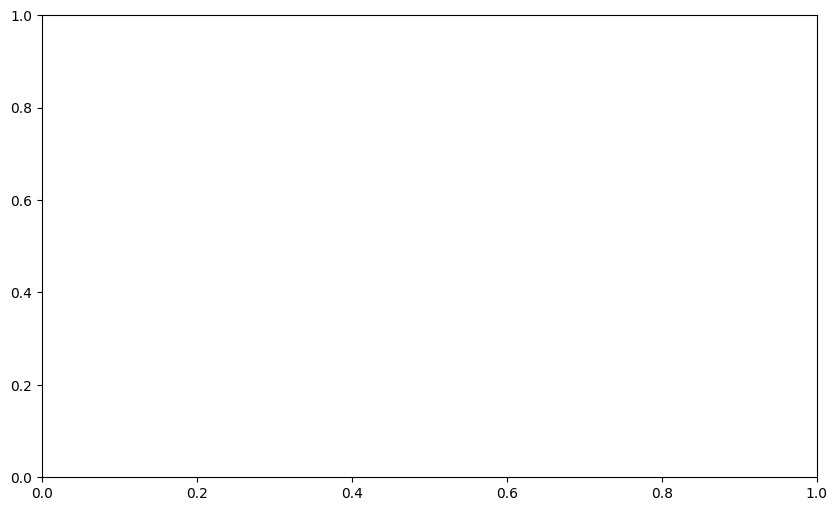

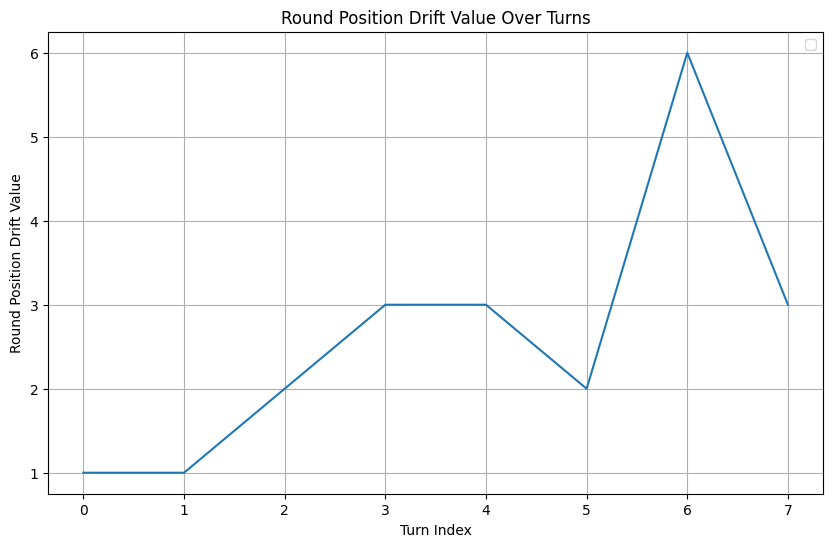

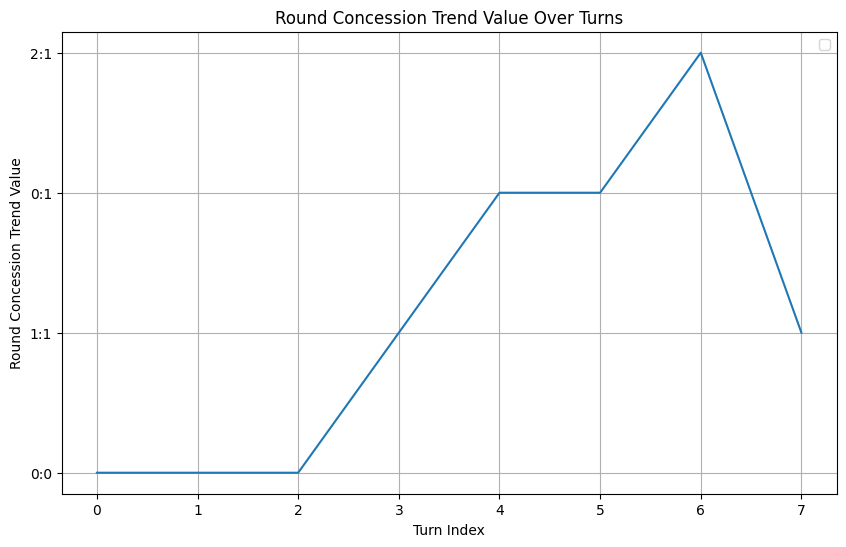

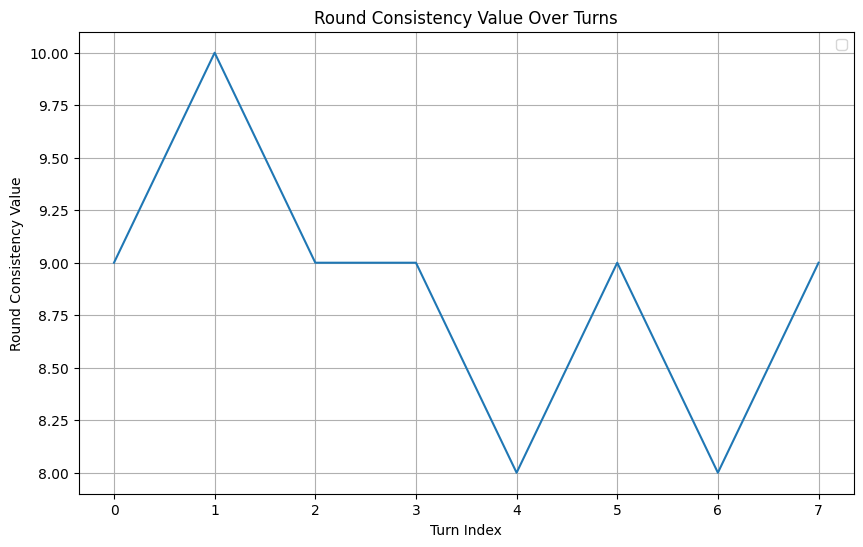

unable to plot for round_bias_summary_value


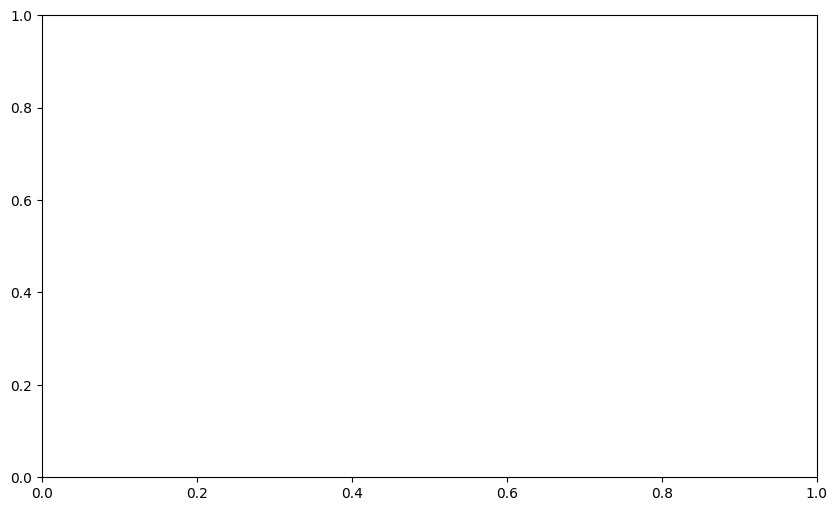

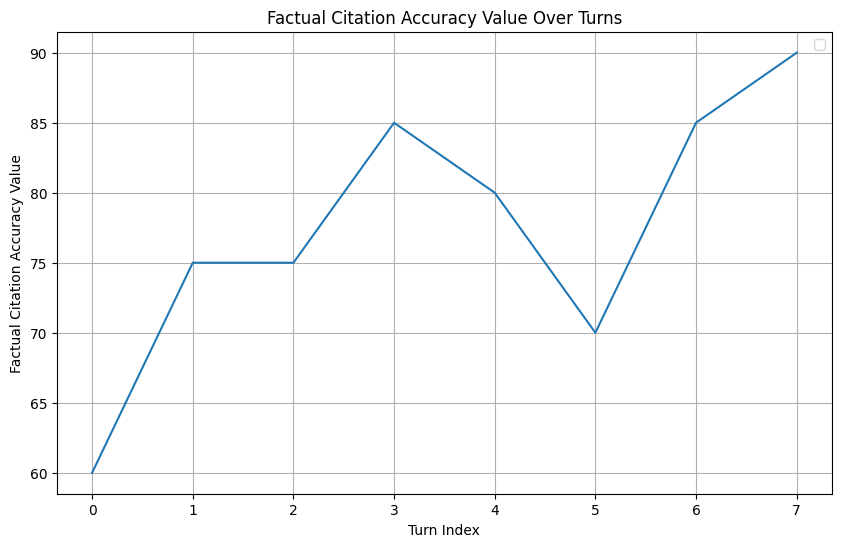

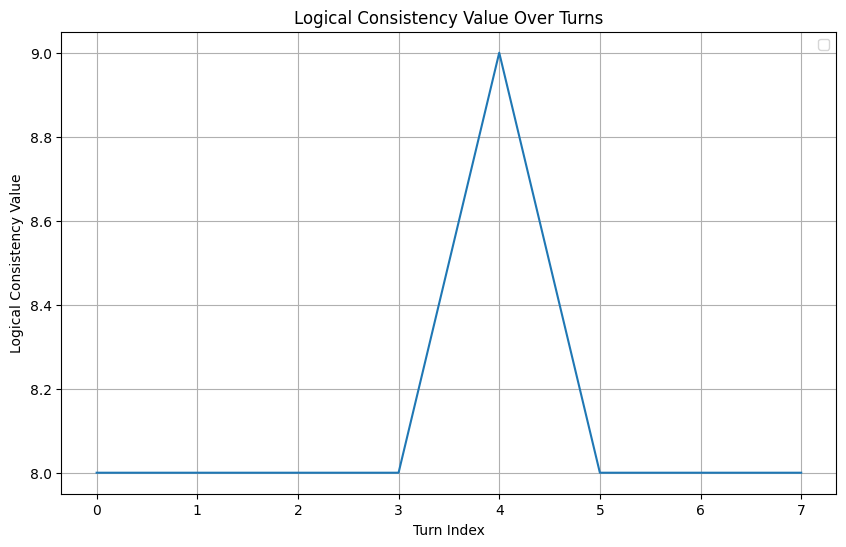

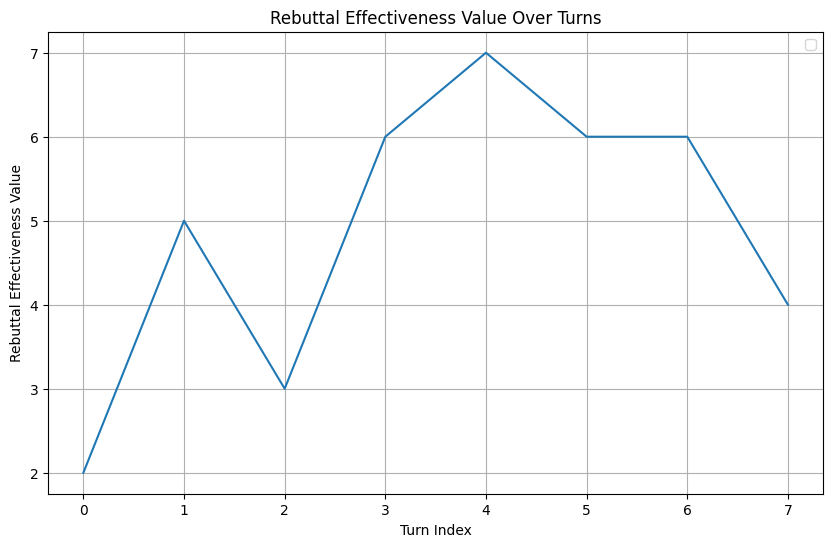

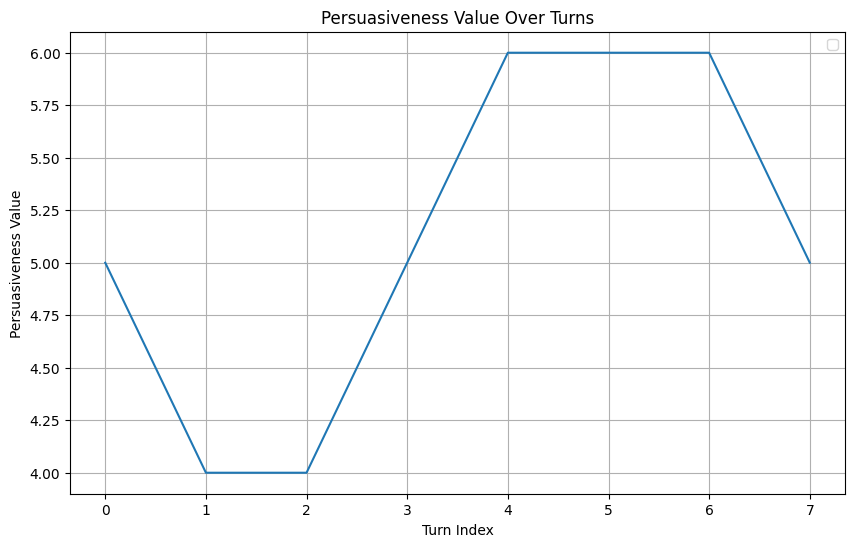

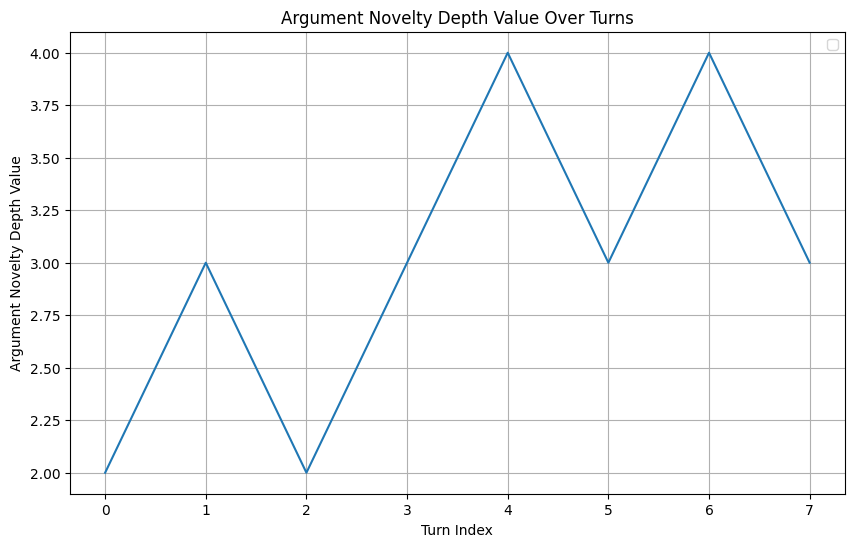

In [58]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def convert_dataframe(data, turn_wise=True):
    rows = []
    for metrics in data:
        row = {}
        if turn_wise:
            row = {'Agent': metrics[0]}
        metrics = metrics[1] if isinstance(metrics, tuple) else metrics
        for metric, value in metrics.items():
            row[metric+"_value"] = np.nan if value["value"] == "N/A" else value["value"]
            row[metric+"_reason"] = np.nan if value["reason"] == "N/A" else value["reason"]
            
        rows.append(row)
    return pd.DataFrame(rows)

def plot_agent_metrics(data, turn_wise):
    # Extract metrics dynamically from the DataFrame columns (excluding Agent)
    metrics = [col for col in data.columns if col != "Agent" and "_value" in col]
    if turn_wise:
        agents = data["Agent"].unique()
    for metric in metrics:
        try:
            plt.figure(figsize=(10, 6))
            if turn_wise:
                for agent in agents:
                    agent_data = data[data["Agent"] == agent].reset_index()
                    plt.plot(agent_data.index, agent_data[metric], label=agent)
            else:
                plt.plot(data[metric])
    
            plt.title(f"{metric.replace('_', ' ').title()} Over Turns")
            plt.xlabel("Turn Index")
            plt.ylabel(metric.replace("_", " ").title())
            plt.legend()
            plt.grid(True)
            plt.savefig(os.path.join(BASE_PATH, f"turn_{metric}_over_turns.png" if turn_wise else f"{metric}_over_turns.png"))
            plt.show()
        except Exception as e:
            print(f"unable to plot for {metric}")
            continue


turn_data = convert_dataframe(turn_evals, turn_wise=True)
plot_agent_metrics(turn_data, turn_wise=True)



round_data = convert_dataframe(round_evals, turn_wise=False)
plot_agent_metrics(round_data, turn_wise=False)